In [7]:
import numpy as np
from scipy.ndimage import correlate1d, correlate, gaussian_filter, median_filter
from skimage.feature.template import match_template
from skimage.draw import disk
import matplotlib.pyplot as plt
from diffpy.structure import loadStructure

In [8]:
Al_Structure = loadStructure("data/Al.cif")

In [9]:
from scipy.spatial.transform import Rotation as R

# Testing to Get an Idea of Performance 

We are going to simulate a pretty rough 4-D STEM data set of a bunch of Al nano-crystals.  We could do this using something like ABTEM but in this case kinematic diffraction is probably fine.  The biggest change would be things like contrast in the diffraction disks and some other thickness effects.  In this case wer are more interested in seeing the effects of:


1. The Number of Different Strucutures
2. Shot/Poission Noise 


Taking a page from the ML community we can test things like percision and recall as a function of these two parameters.  This gives us a good idea of when the method starts to break down as the number of strucutures is increased or when the noise is increased. 

In [10]:
from utils import *

## Plotting Real Space Crystals

In [11]:
num_crystals = [40, 80, 120, 200, 400, 600, 1200]

In [12]:
simulations = [CrystalSTEMSimulation(Al_Structure, real_space_pixels=256, num_crystals=i) for i in num_crystals]

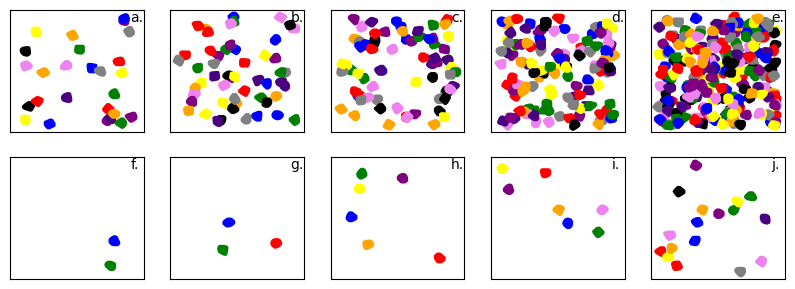

In [13]:
fig, axs = plt.subplots(2,5, figsize=(10,3.5))
labels = ["a", "b", "c", "d", "e"]
for ax,s,l in zip(axs[0,:], simulations, labels):
    s.plot_real_space(ax=ax, remove_below_n=1)
    ax.text(.9,.9, s=l+".", transform=ax.transAxes)

labels = ["f", "g", "h", "i", "j"]
for ax,s,l in zip(axs[1,:], simulations, labels):
    s.plot_real_space(ax=ax, remove_non_symmetric=True)
    ax.text(.9,.9, s=l+".", transform=ax.transAxes)

Figure __: Figure __ shows a the spatial extent of the nanocrystals in real space for [10, 20, 30, and 50] nano crystals respectively. 

You can see that there are progressively more and more overlapping strucutures as the number of crystals increases, however, only some of those crystals are orientated such that they diffract strongly and fewer are oriented so that they diffract on some high symmetry zone axis. 



## Testing Method Performance Visually

In [7]:
import hyperspy.api as hs
arr = simulations[4].make_4d_nano(num_electrons=1, noise_level=.1)
signal = hs.signals.Signal2D(arr)
signal.set_signal_type("electron_diffraction")
filtered = signal.filter("gaussian_filter", sigma=(1,1,0,0))
template = filtered.template_match_disk(disk_r=5, subtract_min=False)

template = filtered.template_match_disk(disk_r=5, subtract_min=False,show_progressbar=False)
template.data[:,:,:, 0:5]=0
template.data[:,:,:,-5:]=0
template.data[:,:, 0:5, :]=0
template.data[:,:,-5:, :]=0


NameError: name 'simulations' is not defined

In [ ]:
pks = template.find_peaks(threshold_abs=0.4, interactive=False,show_progressbar=False )
from pyxem.signals.diffraction_vectors import DiffractionVectors
vect = DiffractionVectors.from_peaks(pks, center= (32, 32),
                                                 calibration=(1/32,1/32))
filt = vect.filter_magnitude(.05,.9, show_progressbar=False )

from scipy.spatial import KDTree
flat = filt.flatten_diffraction_vectors()

In [ ]:
signal.axes_manager.signal_axes[0].offset=-1
signal.axes_manager.signal_axes[1].offset=-1
signal.axes_manager.signal_axes[1].scale=1/32
signal.axes_manager.signal_axes[0].scale=1/32

In [ ]:
offsets = convert_flat_to_markers(flat.data, signal=signal)
offsets2 = convert_flat_to_markers(simulations[4].vectors, signal=signal)
facecolors = np.empty(signal.axes_manager.navigation_shape, dtype=object)
for i in np.ndindex(signal.axes_manager.navigation_shape):
    facecolors[i]=("none",)
    
c = hs.plot.markers.Circles(offsets=offsets, sizes=.05,facecolor=facecolors, color="b")
c2 = hs.plot.markers.Circles(offsets=offsets2, sizes=.0025, color="r")

signal.plot(vmax="95th")
signal.add_marker(c)
signal.add_marker(c2)

In [ ]:
%matplotlib ipympl
template.data[:,:,:, 0:5]=0
template.data[:,:,:,-5:]=0
template.data[:,:, 0:5, :]=0
template.data[:,:,-5:, :]=0
template.plot(vmin=0.35)

## Testing the Recall Performance

Here we are going to test the performance vs overlapping strucutures.  As things start to overlap by a fair ammount then diffraction vectors will start to be "missed" and as a result we see worse performance

## Code for Creating the Recall Data Plotted Below

In [7]:
import hyperspy.api as hs
hs.set_log_level("ERROR")
hs.preferences.General.show_progress_bar=False
for i in range(6):
    num_crystals = [40, 80, 120, 200, 400, 600, 1200]
    simulations = [CrystalSTEMSimulation(Al_Structure, real_space_pixels=256, num_crystals=i) for i in num_crystals]
    with open("recall"+str(i)+".txt","w+") as f:
        f.write("num_crystals, recall, false_positives \n")
        from skimage.draw import disk
        mask = np.ones((64,64), dtype=bool)
        rr,cc = disk((32,32), 10)
        mask[rr,cc]=False
        for s, num_crystal in zip(simulations,num_crystals):
            arr = s.make_4d_nano(num_electrons=10)
            ground_truth_vectors = s.vectors
            print(np.sum(arr[:,:, mask])/(256 * 256), "Average Electrons per Frame")
            signal = hs.signals.Signal2D(arr)
            signal.set_signal_type("electron_diffraction")
            signal = signal.as_lazy()
            signal.rechunk((32,32))

            filtered = signal.filter("gaussian_filter", sigma=(1,1,0,0))
            template = filtered.template_match_disk(disk_r=5, subtract_min=False,show_progressbar=False)
            template.data[:,:,:, 0:5]=0
            template.data[:,:,:,-5:]=0
            template.data[:,:, 0:5, :]=0
            template.data[:,:,-5:, :]=0
            pks = template.find_peaks(threshold_abs=0.5, interactive=False,show_progressbar=False )
            from pyxem.signals.diffraction_vectors import DiffractionVectors
            vect = DiffractionVectors.from_peaks(pks, center= (32, 32),
                                                     calibration=(1/32,1/32))
            vect.compute()
            filt = vect.filter_magnitude(.05,
                                         .8,
                                             show_progressbar=False )
            ground_truth_vectors = ground_truth_vectors[(ground_truth_vectors[:,2]**2+ground_truth_vectors[:,3]**2)**0.5>0.05]
            ground_truth_vectors = ground_truth_vectors[(ground_truth_vectors[:,2]**2+ground_truth_vectors[:,3]**2)**0.5<0.8]

            from scipy.spatial import KDTree
            flat = filt.flatten_diffraction_vectors()
            ground_truth_vectors[:,2:4] = ground_truth_vectors[:,2:4]*32
            flat.data[:,2:] = flat.data[:,2:]*32
            gt_tree = KDTree(ground_truth_vectors[:,0:4])
            flat_tree = KDTree(flat.data)

            false_positives = [len(i) == 0 for i in gt_tree.query_ball_point(flat.data, r=9)]

            is_bigger = [len(i)>1 for i in flat_tree.query_ball_point(ground_truth_vectors[:,:4], r=2)]
            r = np.sum(is_bigger)/len(is_bigger)
            fp = np.sum(false_positives)/ len(false_positives)
            print("Recall ", r) 
            print("False Positives", fp)
            f.write(str(num_crystal)+", " + str(r)+", "+ str(fp)+"\n")

/Users/carterfrancis/mambaforge/envs/development/lib/python3.10/site-packages/diffsims/generators/sphere_mesh_generators.py:514: RuntimeWarning: invalid value encountered in divide
  phi2 = sign * np.nan_to_num(np.arccos(x_comp / norm_proj))


KeyboardInterrupt: 

## Recall Data

In [13]:
recall = [np.loadtxt("recall"+str(i)+".txt", delimiter=",", skiprows=1) for i in range(6)]
mean_recall = np.mean(recall, axis=0)
std_recall = np.std(recall, axis=0)

In [14]:
mean_recall

array([[4.00000000e+01, 9.97531896e-01, 7.52986115e-04],
       [8.00000000e+01, 9.90739926e-01, 1.44263297e-03],
       [1.20000000e+02, 9.79555843e-01, 1.99847371e-03],
       [2.00000000e+02, 9.79184400e-01, 4.57665597e-03],
       [4.00000000e+02, 9.48484621e-01, 3.74569259e-03],
       [6.00000000e+02, 9.15870844e-01, 2.83817678e-03],
       [1.20000000e+03, 8.28627179e-01, 1.80862916e-03]])

In [15]:
num_crystals = [40, 80, 120, 200, 400, 600, 1200]
simulations = [CrystalSTEMSimulation(Al_Structure, real_space_pixels=256, num_crystals=i) for i in num_crystals]

/Users/carterfrancis/mambaforge/envs/development/lib/python3.10/site-packages/diffsims/generators/sphere_mesh_generators.py:514: RuntimeWarning: invalid value encountered in divide
  phi2 = sign * np.nan_to_num(np.arccos(x_comp / norm_proj))


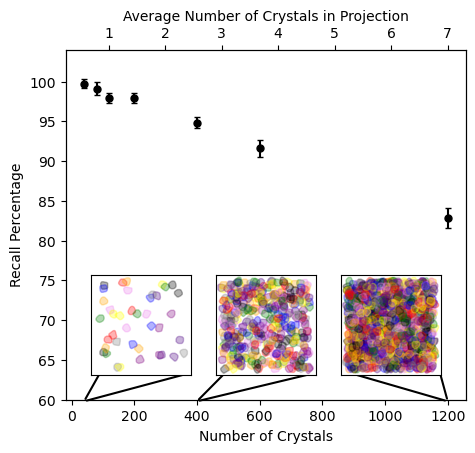

In [24]:
fig = plt.figure(figsize=(5,5))

axs = fig.add_axes((.15,.15, 0.8,0.7))
axs.errorbar(mean_recall[:,0],
             mean_recall[:,1]*100,
             std_recall[:,1]*100,
             capsize=2, color="black",ls="none",
             marker="o", markersize=5
            )
axs.set_xlabel("Number of Crystals")
axs.set_ylabel("Recall Percentage")
top = axs.twiny()

top.set_xlim((400*40)/(256*256), (400*1200)/(256*256))
top.set_xlabel("Average Number of Crystals in Projection")
axs.set_ylim(60,104)
corners = [.2,.45,.7]

axs2 = fig.add_axes((.2,.2, 0.2,0.2))

axs3 = fig.add_axes((.45,.2, 0.2,0.2))

axs4 = fig.add_axes((.7,.2, 0.2,0.2))

for ax in [axs2,axs3,axs4]:
    ax.set_xticks([])
    ax.set_yticks([])
    
for a, i,c in zip([axs2, axs3, axs4], [0,4,6], corners):
    simulations[i].plot_real_space(ax=a, alpha=0.3)

    axs.annotate("", xy=(num_crystals[i],59.8), xytext=(c, .16), xycoords="data",
                 textcoords="figure fraction",
                 arrowprops=dict(facecolor='black',arrowstyle="-", lw=1.5),annotation_clip=False)
    axs.annotate("", xy=(num_crystals[i],59.8), xytext=(c+0.18, .16), xycoords="data",
                 textcoords="figure fraction",
                 arrowprops=dict(facecolor='black',arrowstyle="-", lw=1.5),annotation_clip=False)

fig.savefig("Figures/Figure4-RecallPercentageVsOverlap.png",bbox_inches="tight" )
plt.show()

## Code for Creating Recall vs Noise Performance

In [ ]:
import hyperspy.api as hs
hs.set_log_level("ERROR")
hs.preferences.General.show_progress_bar=False
num_electrons =[0.001, 0.002,0.004,0.005,.01] 
for i in range(6):
    sim = CrystalSTEMSimulation(Al_Structure, real_space_pixels=256, num_crystals=40)
    with open("num_electrons"+str(i)+".txt","w+") as f:
        f.write("num_crystals, recall, false_positives, electrons_per_vector \n")
        from skimage.draw import disk
        mask = np.ones((64,64), dtype=bool)
        rr,cc = disk((32,32), 10)
        mask[rr,cc]=False
        for s, n in zip(simulations,num_electrons):
            arr = s.make_4d_nano(num_electrons=n)
            ground_truth_vectors = s.vectors
            print(np.sum(arr[:,:, mask])/(256 * 256), "Average Electrons per Frame")
            signal = hs.signals.Signal2D(arr)
            signal.set_signal_type("electron_diffraction")
            signal = signal.as_lazy()
            signal.rechunk((32,32))

            filtered = signal.filter("gaussian_filter", sigma=(1,1,0,0))
            template = filtered.template_match_disk(disk_r=5, subtract_min=False,show_progressbar=False)
            template.data[:,:,:, 0:5]=0
            template.data[:,:,:,-5:]=0
            template.data[:,:, 0:5, :]=0
            template.data[:,:,-5:, :]=0
            pks = template.find_peaks(threshold_abs=0.4, interactive=False,show_progressbar=False )
            from pyxem.signals.diffraction_vectors import DiffractionVectors
            vect = DiffractionVectors.from_peaks(pks, center= (32, 32),
                                                     calibration=(1/32,1/32))
            vect.compute()
            filt = vect.filter_magnitude(.05,
                                         .8,
                                             show_progressbar=False )
            ground_truth_vectors = ground_truth_vectors[(ground_truth_vectors[:,2]**2+ground_truth_vectors[:,3]**2)**0.5>0.05]
            ground_truth_vectors = ground_truth_vectors[(ground_truth_vectors[:,2]**2+ground_truth_vectors[:,3]**2)**0.5<0.8]

            from scipy.spatial import KDTree
            flat = filt.flatten_diffraction_vectors()
            ground_truth_vectors[:,2:4] = ground_truth_vectors[:,2:4]*32
            flat.data[:,2:] = flat.data[:,2:]*32
            gt_tree = KDTree(ground_truth_vectors[:,0:4])
            flat_tree = KDTree(flat.data)

            false_positives = [len(i) == 0 for i in gt_tree.query_ball_point(flat.data, r=9)]

            is_bigger = [len(i)>1 for i in flat_tree.query_ball_point(ground_truth_vectors[:,:4], r=2)]
            r = np.sum(is_bigger)/len(is_bigger)
            fp = np.sum(false_positives)/ len(false_positives)
            electrons_per_vector = np.mean(ground_truth_vectors[:,-1])*n*69
            print("electrons_per_vector", electrons_per_vector)
            
            print("Recall ", r) 
            print("False Positives", fp)
            f.write(str(n)+", " + str(r)+", "+ str(fp)+", "+ str(electrons_per_vector) +"\n")

## Recall vs Noise:

In [2]:
import numpy as np

In [3]:
recall = [np.loadtxt("num_electrons"+str(i)+".txt", delimiter=",", skiprows=1) for i in range(6)]
mean_recall = np.mean(recall, axis=0)
std_recall = np.std(recall, axis=0)

In [4]:
mean_recall[:,-1]

array([ 3.60815344,  6.58228401, 13.01147019, 16.67170585, 30.19221735])

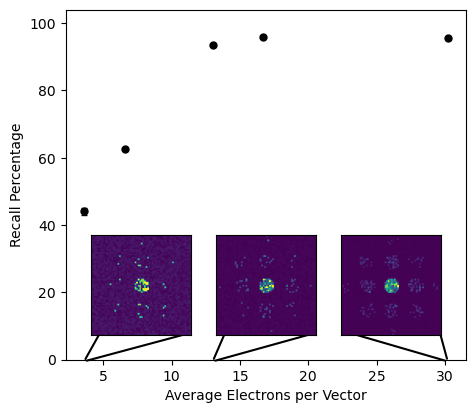

In [26]:
fig = plt.figure(figsize=(5,5))

axs = fig.add_axes((.15,.15, 0.8,0.7))
axs.errorbar(mean_recall[:,-1],
             mean_recall[:,1]*100,
             std_recall[:,1]*100, 
             capsize=2, color="black",ls="none",
             marker="o", markersize=5
            )
axs.set_xlabel("Average Electrons per Vector")
axs.set_ylabel("Recall Percentage")
axs.set_ylim(0,104)

axs2 = fig.add_axes((.2,.2, 0.2,0.2))

axs3 = fig.add_axes((.45,.2, 0.2,0.2))

axs4 = fig.add_axes((.7,.2, 0.2,0.2))

for ax in [axs2,axs3,axs4]:
    ax.set_xticks([])
    ax.set_yticks([])

simulations[0].plot_example_dp(ax=axs2,threshold=0.6, num_electrons=0.001)
simulations[4].plot_example_dp(ax=axs3,threshold=0.6, num_electrons=0.004)
simulations[-1].plot_example_dp(ax=axs4, threshold=0.6, num_electrons=0.01)



for a, i,c in zip([axs2, axs3, axs4], [0,2,-1], corners):
    axs.annotate("", xy=(mean_recall[:,-1][i],-0.5), xytext=(c, .16), xycoords="data",
                 textcoords="figure fraction",
                 arrowprops=dict(facecolor='black',arrowstyle="-", lw=1.5),annotation_clip=False)
    axs.annotate("", xy=(mean_recall[:,-1][i],-0.5), xytext=(c+0.18, .16), xycoords="data",
                 textcoords="figure fraction",
                 arrowprops=dict(facecolor='black',arrowstyle="-", lw=1.5),annotation_clip=False)
fig.savefig("Figures/Figure3-RecallVsNoise.png", bbox_inches="tight" )
plt.show()

## Extracting Structures

Now that we have a pretty good idea about how many strucutures we are finding we can move to clustering them and creating the "nano-crystal" diffraction patterns.

This will break down before the peak finding algorithm does mostly because it isn't terribly smart.  There are additional ways you could think about doing this like looking at the extents of the vectors in real space, but somtimes intensity variations between peaks cause some weird problems there.

More than likely the best thing to do would be to train something like a Neural Network or include some previous knowledge (Hey if we know the crystal strucuture!  ;) ) and that would make the segmentation far more robust. 

But this is more of a proof of concept and is therefore "good-enough"

## More Helper Functions

In [116]:
np.subtract(*[1,2])

-1

In [128]:
def unwrap(pks):
    r = np.linalg.norm(pks[:,:2], axis=1) # ignore the intensity
    theta = np.arctan2(pks[:,0],pks[:,1])
    return np.stack((r,theta,pks[:,2]), axis=1)

import itertools
def get_intensity_filtered_combinations(pks,
                                        num,
                                        angle_index=1,
                                        intensity_index=2,
                                        intensity_threshold=0.5, min_angle=None):
    """
    Creates combinations of `num` peaks but forces at least one of the combinations to have
    an intensity higher than the `intensity_threshold`.
    This filter is useful for finding high intensity features but not losing lower intensity
    paired features which contribute to symmetry etc.
    """
    angles = pks[:,angle_index]
    intensity = pks[:,intensity_index]
    angle_combos = itertools.combinations(angles,num)
    intensity_combos = itertools.combinations(intensity,num)
    filtered_combos = [a for a, i in zip(angle_combos,intensity_combos) 
                        if any(np.array(i)>intensity_threshold)]
    if min_angle is not None:
        filtered_combos = [a for a in filtered_combos if 
                            all([np.abs(np.subtract(*c))>min_angle for c in itertools.combinations(a,2)])]
    
    return filtered_combos



def get_three_angles(pks,
                     angle_index=1,
                     intensity_index=2,
                     intensity_threshold=None,
                     accept_threshold=0.05,
                     get_min=True,
                     include_multi=False,
                    ):
    """
    This function takes the angle between three points and determines the angle between them,
    returning the angle if it is repeated using the `accept_threshold` to measure the acceptable
    difference between angle a and angle b
           o
           |
           |_   angle a
           | |
           x--------o
           |_|
           |    angle b
           |
           o
    """
    three_angles = []
    if intensity_threshold is not None:
        combos = get_intensity_filtered_combinations(pks,
                                                     3,
                                                     angle_index=angle_index,
                                                     intensity_index=intensity_index,
                                                     intensity_threshold=intensity_threshold)
    else:
        angles = pks[:,angle_index]
        combos = itertools.combinations(angles,3)
    for c in combos:
        angular_seperations = get_angles(c)
        min_ind = np.argmin(angular_seperations)
        min_sep = angular_seperations[min_ind]
        angular_seperations = np.delete(angular_seperations, min_ind)
        if np.any(np.abs((angular_seperations - min_sep))<accept_threshold):
            for a in angular_seperations:
                three_angles.append(a)
            three_angles.append(min_sep)
    return three_angles


import numpy as np
def unwrap(pks):
    r = np.linalg.norm(pks, axis=1)
    theta = np.arctan2(pks[:,0],pks[:,1])
    return np.stack((r,theta), axis=1)


def get_angles(angles):
    all_angles = np.abs(np.triu(np.subtract.outer(angles, angles)))
    all_angles = all_angles[all_angles != 0]
    all_angles[all_angles > np.pi] = np.pi-np.abs(all_angles[all_angles > np.pi]-np.pi)
    return all_angles


import numpy as np
from copy import deepcopy
def convert_to_labeled_markers(peaks,
                       signal,
                       polar=True,
                       return_marker=False,
                       **kwargs):
    new_peaks = deepcopy(peaks.data)
    x_axis, y_axis = signal.axes_manager.navigation_axes
    new_peaks[:,0]= np.round((new_peaks[:,0]-x_axis.offset)/x_axis.scale)
    new_peaks[:,1]= np.round((new_peaks[:,1]-y_axis.offset)/y_axis.scale)
    ind = np.lexsort((new_peaks[:,1],new_peaks[:,0]))
    sorted_peaks = new_peaks[ind]
    x,y = signal.axes_manager.signal_axes
    shape = signal.axes_manager.navigation_shape
    by_ind_peaks = np.empty(shape,dtype=object)
    by_ind_colors = np.empty(shape,dtype=object)
    num_labels = np.max(new_peaks[:,-1])
    colors_by_index = np.random.random((int(num_labels+1),3))*0.9 # (Stay away from white)
    colors_by_index = np.vstack((colors_by_index, [1,1,1]))
    low_x_ind = np.searchsorted(sorted_peaks[:,0],range(0,shape[0]), side="left")
    high_x_ind = np.searchsorted(sorted_peaks[:,0],range(1,shape[0]+1), side="left")
    #print(low_x_ind)
    #print(high_x_ind)
    for i, (lo_x,hi_x) in enumerate(zip(low_x_ind, high_x_ind)):
        x_inds = sorted_peaks[lo_x:hi_x]
        low_y_ind = np.searchsorted(x_inds[:,1],range(0,shape[1]), side="left")
        high_y_ind = np.searchsorted(x_inds[:,1],range(1,shape[1]+1), side="left")
        for j, (lo_y,hi_y) in enumerate(zip(low_y_ind, high_y_ind)):
            x_values = x_inds[lo_y:hi_y, 2]
            y_values = x_inds[lo_y:hi_y, 3]
            #print(lo_x,hi_x, lo_y, hi_y)
            labels = np.array(x_inds[lo_y:hi_y, -1], dtype=int)
            by_ind_peaks[i,j] = np.stack((y_values, x_values), axis=1)
            by_ind_colors[i,j] = colors_by_index[labels]
    return by_ind_peaks, by_ind_colors, colors_by_index


from scipy.spatial import ConvexHull, convex_hull_plot_2d
def points_to_poly_collection(points, hull_index=(0,1)):
    try:
        hull = ConvexHull(points[:,hull_index][:,::-1])
    except:
        return np.array([[0,0],[0,0],[0,0]])
    return hull.points[hull.vertices]


from sklearn.cluster import OPTICS
from pyxem.utils.labeled_vector_utils import column_mean
def cluster_labeled_vectors(self,
                            eps=2,
                            min_samples=2):
    mean_pos = self.map_vectors(column_mean,
                                columns=[0, 1],
                                label_index=-1,
                                dtype=float,
                                shape=(2,))
    vectors =self.data
    clustering = OPTICS(min_samples=min_samples, max_eps=eps).fit(mean_pos)
    labels = clustering.labels_
    initial_labels = self.data[:, -1].astype(int)
    new_labels = labels[initial_labels]
    new_labels[initial_labels == -1] = -1
    print(f"{np.max(labels) + 1} : Clusters Found!")
    vectors_and_labels = np.hstack([vectors, new_labels[:, np.newaxis]])
    new_signal = self._deepcopy_with_new_data(data=vectors_and_labels)
    new_signal.axes_manager.signal_axes[0].size = new_signal.axes_manager.signal_axes[0].size + 1
    new_signal.is_clustered = True
    return new_signal

## Plotting things

In [ ]:
offsets,colors, colors_by_index  = convert_to_labeled_markers(clust, signal)
vert = clust.map_vectors(points_to_poly_collection,
                                 dtype=object)
vert = [v for v in vert]

In [ ]:
facecolors = np.empty(signal.axes_manager.navigation_shape, dtype=object)
for i in np.ndindex(signal.axes_manager.navigation_shape):
    facecolors[i]=("none",)
    
c = hs.plot.markers.Circles(offsets=offsets, sizes=.05,
                            facecolor=facecolors,
                            color=colors, alpha=0.5)
p = hs.plot.markers.Polygons(verts=vert, 
                             color=colors_by_index,
                             alpha=0.5)

signal.plot(vmax="95th")
signal.add_marker(c)
signal.add_marker(p,plot_on_signal=False)

## Code to Make Data for Recall Crystals

In [ ]:
plt.close("all")

In [ ]:
s = CrystalSTEMSimulation(Al_Structure, real_space_pixels=256, num_crystals=40) 

In [ ]:
import hyperspy.api as hs
from scipy.spatial import KDTree
arr = s.make_4d_nano(num_electrons=10)
ground_truth_vectors = s.vectors
signal = hs.signals.Signal2D(arr)
signal.set_signal_type("electron_diffraction")
signal = signal.as_lazy()
signal.rechunk((32,32))

filtered = signal.filter("gaussian_filter",
                         sigma=(1,1,0,0))
template = filtered.template_match_disk(disk_r=5,
                                        subtract_min=False,
                                            show_progressbar=False)
template.data[:,:,:, 0:5]=0
template.data[:,:,:,-5:]=0
template.data[:,:, 0:5, :]=0
template.data[:,:,-5:, :]=0
pks = template.find_peaks(threshold_abs=0.5,
                          interactive=False,
                          show_progressbar=False )
from pyxem.signals.diffraction_vectors import DiffractionVectors
vect = DiffractionVectors.from_peaks(pks,
                                     center= (32, 32),
                                     calibration=(1/32,1/32))
vect.compute()
filt = vect.filter_magnitude(.05,.85,show_progressbar=False )

flat = filt.flatten_diffraction_vectors()
signal.axes_manager.signal_axes[0].offset=-1
signal.axes_manager.signal_axes[1].offset=-1
signal.axes_manager.signal_axes[1].scale=1/32
signal.axes_manager.signal_axes[0].scale=1/32
cords = s.get_coords(low=0.1, high=0.8)
filtered_centers = s.centers[[len(c)>1 for c in cords]]
lab = flat.cluster_vectors(real_space_distance_threshold=2,
                           recip_space_distance_threshold=0.05)
clust = cluster_labeled_vectors(lab, eps=5)


######
# New
#####
means = clust.map_vectors(column_mean,columns=[0, 1,],
                          label_index=-1,
                          dtype=float,
                          shape=(2,))
center_means = clust.map_vectors(get_centers, dtype=object)

filtered_coords = s.get_coords(.1,0.8)
filtered_centers = [cen for cen, c in zip(s.centers, filtered_coords) if len(c)>1]
filtered_coords = [c for c in filtered_coords if len(c)>1]

mean_tree= KDTree(means)
# testing recall percentage
in_range = [m for m in mean_tree.query_ball_point(filtered_centers, r=4)]


recall_percents =[]
for ground_truth, ind in zip(filtered_coords, in_range):
    gt_tree = KDTree(ground_truth[:,:2])
    recall_percent = []
    for i in ind:
        inside = np.sum([len(r)>0 for r in gt_tree.query_ball_point(center_means[i][:,:2], r=0.1)])
        recall_percent.append(inside/len(ground_truth))
        
    if len(recall_percent)==0:
        recall_percents.append(np.nan)
    else:
        recall_percents.append(np.max(recall_percent))
unique, counts = np.unique(recall_percents, return_counts=True)
print(unique, counts)
perfect_recall_percent = np.sum(counts[unique>=1])/np.sum(counts)
print("Perfect Recall", perfect_recall_percent)
partial_recall_percent = np.sum(counts[unique>0])/np.sum(counts)
print("Partial Recall", partial_recall_percent)


In [ ]:
means = clust.map_vectors(column_mean,columns=[0, 1,],
                          label_index=-1,
                          dtype=float,
                          shape=(2,))
center_means = clust.map_vectors(get_centers, dtype=object)

In [ ]:
filtered_coords = s.get_coords(.1,0.8)
filtered_centers = [cen for cen, c in zip(s.centers, filtered_coords) if len(c)>1]
filtered_coords = [c for c in filtered_coords if len(c)>1]

In [ ]:
mean_tree= KDTree(means)
# testing recall percentage
in_range = [m for m in mean_tree.query_ball_point(filtered_centers, r=4)]

In [ ]:
recall_percents =[]
for ground_truth, ind in zip(filtered_coords, in_range):
    gt_tree = KDTree(ground_truth[:,:2])
    recall_percent = []
    for i in ind:
        inside = np.sum([len(r)>0 for r in gt_tree.query_ball_point(center_means[i][:,:2], r=0.02)])
        recall_percent.append(inside/len(ground_truth))
        
    if len(recall_percent)==0:
        recall_percents.append(np.nan)
    else:
        recall_percents.append(np.max(recall_percent))
unique, counts = np.unique(recall_percents, return_counts=True)
print(unique, counts)
perfect_recall_percent = np.sum(counts[unique>=1])/np.sum(counts)
print("Perfect Recall", perfect_recall_percent)
partial_recall_percent = np.sum(counts[unique>0])/np.sum(counts)
print("Partial Recall", partial_recall_percent)

In [ ]:
for i in range(6):
    num_crystals = [40, 80, 120, 200, 400, 600, 1200]
    simulations = [CrystalSTEMSimulation(Al_Structure, real_space_pixels=256, num_crystals=i) for i in num_crystals]
    with open("recall_crystals"+str(i)+".txt","w+") as f:
        f.write("num_crystals, perfect_recall, partial_recall \n")
        from skimage.draw import disk
        mask = np.ones((64,64), dtype=bool)
        rr,cc = disk((32,32), 10)
        mask[rr,cc]=False
        for s, num_crystal in zip(simulations,num_crystals):
            arr = s.make_4d_nano(num_electrons=10)
            ground_truth_vectors = s.vectors
            signal = hs.signals.Signal2D(arr)
            signal.set_signal_type("electron_diffraction")
            signal = signal.as_lazy()
            signal.rechunk((32,32))

            filtered = signal.filter("gaussian_filter",
                         sigma=(1,1,0,0))
            template = filtered.template_match_disk(disk_r=5,
                                        subtract_min=False,
                                            show_progressbar=False)
            template.data[:,:,:, 0:5]=0
            template.data[:,:,:,-5:]=0
            template.data[:,:, 0:5, :]=0
            template.data[:,:,-5:, :]=0
            pks = template.find_peaks(threshold_abs=0.5,
                          interactive=False,
                          show_progressbar=False )
            from pyxem.signals.diffraction_vectors import DiffractionVectors
            vect = DiffractionVectors.from_peaks(pks,
                                     center= (32, 32),
                                     calibration=(1/32,1/32))
            vect.compute()
            filt = vect.filter_magnitude(.05,.85,show_progressbar=False )

            flat = filt.flatten_diffraction_vectors()
            signal.axes_manager.signal_axes[0].offset=-1
            signal.axes_manager.signal_axes[1].offset=-1
            signal.axes_manager.signal_axes[1].scale=1/32
            signal.axes_manager.signal_axes[0].scale=1/32
            
            flat = filt.flatten_diffraction_vectors()
            cords = s.get_coords(low=0.1, high=0.8)
            filtered_centers = s.centers[[len(c)>1 for c in cords]]
            lab = flat.cluster_vectors(real_space_distance_threshold=2,
                           recip_space_distance_threshold=0.05)
            clust = cluster_labeled_vectors(lab, eps=5)
            
            
            means = clust.map_vectors(column_mean,columns=[0, 1,],
                          label_index=-1,
                          dtype=float,
                          shape=(2,))
            
            
            center_means = clust.map_vectors(get_centers, dtype=object)

            filtered_coords = s.get_coords(.1,0.8)
            filtered_centers = [cen for cen, c in zip(s.centers, filtered_coords) if len(c)>1]
            filtered_coords = [c for c in filtered_coords if len(c)>1]

            mean_tree= KDTree(means)
            # testing recall percentage
            in_range = [m for m in mean_tree.query_ball_point(filtered_centers, r=4)]

            recall_percents =[]
            for ground_truth, ind in zip(filtered_coords, in_range):
                gt_tree = KDTree(ground_truth[:,:2])
                recall_percent = []
                for i in ind:
                    inside = np.sum([len(r)>0 for r in gt_tree.query_ball_point(center_means[i][:,:2], r=0.1)])
                    recall_percent.append(inside/len(ground_truth))

                if len(recall_percent)==0:
                    recall_percents.append(np.nan)
                else:
                    recall_percents.append(np.max(recall_percent))
            unique, counts = np.unique(recall_percents, return_counts=True)
            print(unique, counts)
            perfect_recall_percent = np.sum(counts[unique>=1])/np.sum(counts)
            print("Perfect Recall", perfect_recall_percent)
            partial_recall_percent = np.sum(counts[unique>0])/np.sum(counts)
            print("Partial Recall", partial_recall_percent)
            f.write(str(num_crystal)+", " + str(perfect_recall_percent)+", "+ str(partial_recall_percent)+"\n")

## Plotting Recall Crystals

Here we plot the percentage of crystals identified vs the total number of crystals in the field of view.  The method is perfect up to around 200 crystals or so and perform and then overlapping crystals start to break down the performance as crystals are merged.  Better performance could be potentially be achieved by adjusting some of the parameters for clustering, but in most cases this degree of performance is acceptable. 

One thing to note that there are a couple of different failure mechanisms for this method:

1. The crystal is correctly identified by the diffraction spots aren't all accounted for.  This is shown by the "non-perfect" recall which is just a way of saying that 2 or more of the diffraction spots are identified but not all of the diffraction spots are correctly clustered. 

2. Over agglormeration. The clustering methods are greedy in step 1 and step 2.  In this case some set of diffraction vectors is combined and the result is that non-perfect recall occurs. 


This means that in order to look at more complicated crystal systems some pre-knowledge of the crystal should be applied. The best case scienerio would be to include known information about the underlying crystal strucuture like a dictionary of diffraction patterns. This helps to cluster things in a more "intelligent way". In that case though it is almost more likely that thickness effects have rendered the experiment useless. 

In [27]:
recall = [np.loadtxt("recall_crystals"+str(i)+".txt", delimiter=",", skiprows=1) for i in range(6)]
mean_recall = np.mean(recall, axis=0)
std_recall = np.std(recall, axis=0)

In [28]:
num_crystals = [40, 80, 120, 200, 400, 600, 1200]
simulations = [CrystalSTEMSimulation(Al_Structure, real_space_pixels=256, num_crystals=i) for i in num_crystals]

/Users/carterfrancis/mambaforge/envs/development/lib/python3.10/site-packages/diffsims/generators/sphere_mesh_generators.py:514: RuntimeWarning: invalid value encountered in divide
  phi2 = sign * np.nan_to_num(np.arccos(x_comp / norm_proj))


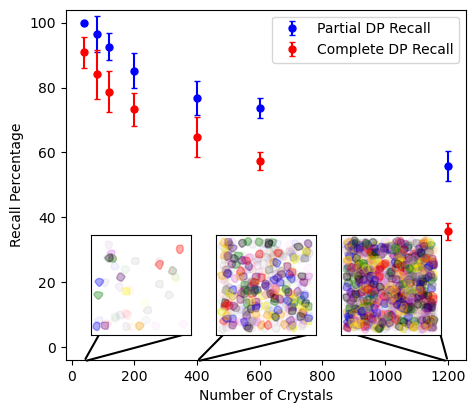

In [31]:
fig = plt.figure(figsize=(5,5))

axs = fig.add_axes((.15,.15, 0.8,0.7))
axs.errorbar(mean_recall[:,0],
             mean_recall[:,2]*100,
             std_recall[:,2]*100,
             capsize=2, color="Blue",ls="none",
             marker="o", markersize=5,
             label="Partial DP Recall")

axs.errorbar(mean_recall[:,0],
             mean_recall[:,1]*100,
             std_recall[:,1]*100,
             capsize=2, color="Red",ls="none",
             marker="o", markersize=5, label="Complete DP Recall")


axs.set_xlabel("Number of Crystals")
axs.set_ylabel("Recall Percentage")
axs.set_ylim(-4,104)

axs2 = fig.add_axes((.2,.2, 0.2,0.2))

axs3 = fig.add_axes((.45,.2, 0.2,0.2))

axs4 = fig.add_axes((.7,.2, 0.2,0.2))

for ax in [axs2,axs3,axs4]:
    ax.set_xticks([])
    ax.set_yticks([])

simulations[0].plot_real_space(ax=axs2, alpha=0.05)
simulations[0].plot_real_space(ax=axs2, remove_below_n=2, alpha=0.3)
simulations[4].plot_real_space(ax=axs3, alpha=0.05)
simulations[4].plot_real_space(ax=axs3, remove_below_n=2, alpha=0.3)
simulations[-1].plot_real_space(ax=axs4, alpha=0.05)
simulations[-1].plot_real_space(ax=axs4,remove_below_n=2, alpha=0.3)

for a, i,c in zip([axs2, axs3, axs4], [0,4,-1], corners):
    axs.annotate("", xy=(num_crystals[i],-4.5), xytext=(c, .16), xycoords="data",
                 textcoords="figure fraction",
                 arrowprops=dict(facecolor='black',arrowstyle="-", lw=1.5),annotation_clip=False)
    axs.annotate("", xy=(num_crystals[i],-4.5), xytext=(c+0.18, .16), xycoords="data",
                 textcoords="figure fraction",
                 arrowprops=dict(facecolor='black',arrowstyle="-", lw=1.5),annotation_clip=False)
    
fig.savefig("Figures/Figure4-RecallOfCrystals.png",bbox_inches="tight" )
axs.legend()
plt.show()

## Stretching to __Very Complex__ Systems

Some times it is necessary to retain good performance to very complicated systems (such as looking at amorphous materials).  In this case we can consider a three angle seperation.  The basic idea is that highly symmetric diffraction patterns should have at least 3 diffraction vectors which have some angle $\phi$  such that for three diffraction vectors they should be seperated by $\phi$, $\phi$, and $2\phi$.

The figure below shows an example of this with 4 fold symmetry. 

For complicated systems this metric is a good way to determine if diffraction vectors belong to the __same__ crystal becuase it is fairly unlikely that three vectors will end up with such a high degree of angular symmetry by chance. 

The figure below shows some large number of crystals filtered for those that have some high degree of angular symmetry as well as the crystals found using the 3 angle metric. 

We can also see how this preforms by plotting the histogram of angles found.  Ideally only symmetries in the crystal would be shown.  So in this case 4 and 6 fold symmetries. 

In [113]:
s = CrystalSTEMSimulation(Al_Structure, real_space_pixels=256, num_crystals=20) 

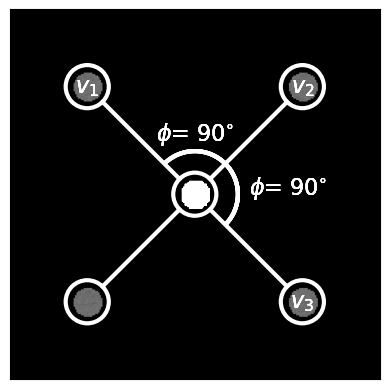

In [158]:
fig, ax = plt.subplots(1,1)
s.plot_example_dp(ax=ax,
                  rotation=(0,0,45),
                  threshold=0.2,
                  num_electrons=10,
                  reciprocal_radius=.6,
                  pixels=256,
                  disk_r=10,cmap="gray"
                 )
ax.set_xticks([])
ax.set_yticks([])

sim = s.generator.calculate_ed_data(s.strucuture,
                                    rotation=(0,0,45),
                                    reciprocal_radius=.6,)

from matplotlib.patches import Circle, Arc
from matplotlib.lines import Line2D
circle_rad=0.07
for c in sim.coordinates:
    cir = Circle(xy=c, radius=circle_rad,facecolor="none", lw=3, edgecolor="w")
    ax.add_patch(cir)

    if not np.sum(np.abs(c[:2]))<0.01:
        ang = np.arctan2(c[1], c[0])
        line_start =  [np.sin(ang)*circle_rad,
                       np.cos(ang)*circle_rad]
        signs = np.sign(c[:2]) * np.sign(line_start)
        line_end = c[:2] - line_start * signs                   
        l = Line2D([line_end[0], line_start[1]], [line_end[1], line_start[0]], color="w", lw=3)
        ax.add_line(l)
    
    v1, v2, v3 = sim.coordinates[3],sim.coordinates[4], sim.coordinates[1]
    ax.text(v1[0],v1[1],"$v_1$", color="w", size=16,horizontalalignment="center",verticalalignment= "center")
    ax.text(v2[0],v2[1],"$v_2$", color="w", size=16,horizontalalignment="center",verticalalignment= "center" )
    ax.text(v3[0],v3[1],"$v_3$", color="w", size=16,horizontalalignment="center", verticalalignment= "center")



    
    arc = Arc(xy=(0,0), width=circle_rad*4, height=circle_rad*4,angle=-45,theta1=0, theta2=180,  color="w", lw=3)
    ax.add_patch(arc)
    ax.text(circle_rad*2.5,0,"$\phi$= 90$^{\circ}$", color="w", size=16)
    ax.text(0,circle_rad*2.5,"$\phi$= 90$^{\circ}$", color="w", size=16,horizontalalignment="center" )

fig.savefig("Figures/Figure4-ThreeVectorExp.png")

## Comments on Glasses:

For an off the cuff calculation if we assume that each strucuture in glass is 1 nm then in a 10 nm x 10 nm x 10nm cube there would be __at most__ 1000 strucutures in the glass. That is about equivlent to the 1200 crystals example. The problem is that at this point we get perfect recall only like 40% of the time.  This is also assuming an ideally diffracting system (which glasses are far from). So a more conservitivate estimate would be around 20%.  The result is that any strucuture could be indentified based on random rotations.  Thing spiral from there if you consider the fact that you also get "false-positives" and there is no ground truth to indentify if something is false.

But we can also just take our metric from above and it fixes the problems from above by __Excluding__ most of the extra stuff and only really focusing on the parts we are interested in (the highly symmetric diffraction patterns :))

In [165]:
def reduced_subtract(min_vector, v2):
    return np.abs(v2-np.round(v2/min_vector)*min_vector)
reduced_subtract(60, 120)

0.0

In [198]:
np.all(True)

True

In [199]:
import itertools
def get_filtered_combinations(pks,
                              num,
                              radial_index=0,
                              angle_index=1,
                              intensity_index=2,
                              intensity_threshold=None,
                              min_angle=None, 
                              min_k=None
                              ):
    """
    Creates combinations of `num` peaks but forces at least one of the combinations to have
    an intensity higher than the `intensity_threshold`.
    This filter is useful for finding high intensity features but not losing lower intensity
    paired features which contribute to symmetry etc.
    """
    angles = pks[:,angle_index]
    k = pks[:, radial_index]

    angle_combos = list(itertools.combinations(angles,num))
    k_combos = list(itertools.combinations(k,num))
    # Filtering out combinations with only diffraction from vectors below the intensity threshold
    if intensity_threshold is not None:
        intensity_combos = itertools.combinations(intensity, num)
        has_min_intensity = np.array([any(np.array(i)>intensity_threshold) for i in intensity_combos])
    else:
        has_min_intensity=True
    # Filtering out combinations where there are two peaks close to each other
    if min_angle is not None:
        above_angle = np.array([all([np.abs(np.subtract(*c))>min_angle for c in itertools.combinations(a,2)])
                         for a in angle_combos])
    else:
        above_angle =True
    # Filtering out combinations of diffraction vectors at different values for k.
    if min_k is not None:
        in_k_range = np.array([np.mean(np.abs(np.subtract(np.mean(k), k))) < k_threshold for k in k_combos])
    else:
        in_k_range=True
    
    in_combos = above_angle*has_min_intensity*in_k_range
    if np.all(in_combos):
        combos = angle_combos
        combos_k = [np.mean(ks) for ks in k_combos]

    else:

        combos = [c for c, in_c in zip(angle_combos,in_combos) if in_c]
        combos_k = [np.mean(ks) for ks, in_range in zip(k_combos,in_combos) if in_range]
    return combos, combos_k



import itertools
def get_three_angles(pks,
                     k_index=0,
                     angle_index=1,
                     intensity_index=2,
                     intensity_threshold=None,
                     accept_threshold=0.05,
                     k_threshold=.1,
                     include_multi=False,
                     return_min=True,
                     multi=True,
                     min_angle=None,
                    ):
    """
    This function takes the angle between three points and determines the angle between them,
    returning the angle if it is repeated using the `accept_threshold` to measure the acceptable
    difference between angle a and angle b
           o
           |
           |_   angle a
           | |
           x--------o
           |_|
           |    angle b
           |
           o
    """
    three_angles = []
    min_angles = []
    combos, combo_k = get_filtered_combinations(pks,3,
                                           angle_index=angle_index,
                                           intensity_index=intensity_index,
                                           intensity_threshold=intensity_threshold,min_angle=min_angle)
    for c,k in zip(combos, combo_k):
        angular_seperations = get_angles(c)
        try:
            min_ind = np.argmin(angular_seperations)
            min_sep = angular_seperations[min_ind]
            angular_seperations = np.delete(angular_seperations, min_ind)
            if multi: # test to see if any of the angles are multiples of each other
                remain = [reduced_subtract(min_sep, a) for a in angular_seperations ]
                remain = [np.abs(f)<accept_threshold for f in remain]
                is_symetric = np.all(remain)
            else:   
                is_symetric = np.any(np.abs((angular_seperations - min_sep))<accept_threshold)
            if is_symetric:
                if not return_min:
                    for a in angular_seperations:
                        three_angles.append(a)
                    three_angles.append(min_sep)
                else:
                    min_angle = np.min(c)
                    num_times = np.round(min_angle/min_sep)
                    three_angles.append([min_angle, min_sep, np.abs(min_angle - (num_times*min_sep)),k])
        except(ValueError):
            print("error")
            print(c)
            print(combos)
            pass
    if len(three_angles)==0:
        three_angles = np.empty((0,4))
    return np.array(three_angles)

def unwrap(pks):
    if len(pks)==0:
        return np.empty((0,3))
    r = np.linalg.norm(pks[:,:2], axis=1) # ignore the intensity
    theta = np.arctan2(pks[:,0],pks[:,1])
    return np.stack((r,theta, pks[:,2]), axis=1)
def filter_mag(z, min_mag, max_mag):
    norm = np.linalg.norm(z[:,:2], axis=1)
    in_range= norm<max_mag*(norm>min_mag)
    return z[in_range]

import numpy as np
from copy import deepcopy
def angles_to_markers(angles,
                      signal,
                      polar=True,
                      return_marker=False,
                      **kwargs):
    """ Convert a set of angles to markers.
    
    Angles are set as [Initial Position, Angular Seperation, Reduced Position, k]
    
    """
    new_angles = deepcopy(angles.data)
    
    # Sorting based on navigation position 
    x_axis, y_axis = signal.axes_manager.navigation_axes
    new_angles[:,0]= np.round((new_angles[:,0]-x_axis.offset)/x_axis.scale)
    new_angles[:,1]= np.round((new_angles[:,1]-y_axis.offset)/y_axis.scale)
    ind = np.lexsort((new_angles[:,1],new_angles[:,0]))
    sorted_peaks = new_angles[ind]
    x,y = signal.axes_manager.signal_axes
    # Create Ragged arrays
    shape = signal.axes_manager.navigation_shape
    by_ind_peaks = np.empty(shape,dtype=object)
    by_ind_colors = np.empty(shape,dtype=object)
    num_labels = np.max(new_angles[:,-1])
    # Random Colors
    colors_by_index = np.random.random((int(num_labels+1),3))*0.9 # (Stay away from white)
    colors_by_index = np.vstack((colors_by_index, [1,1,1]))
    # Serach sorted for speed 
    low_x_ind = np.searchsorted(sorted_peaks[:,0],range(0,shape[0]), side="left")
    high_x_ind = np.searchsorted(sorted_peaks[:,0],range(1,shape[0]+1), side="left")
    for i, (lo_x,hi_x) in enumerate(zip(low_x_ind, high_x_ind)):
        x_inds = sorted_peaks[lo_x:hi_x]
        low_y_ind = np.searchsorted(x_inds[:,1],range(0,shape[1]), side="left")
        high_y_ind = np.searchsorted(x_inds[:,1],range(1,shape[1]+1), side="left")
        for j, (lo_y,hi_y) in enumerate(zip(low_y_ind, high_y_ind)):
            # Get positions
            initial_theta = x_inds[lo_y:hi_y, 2]
            angle_seperation = x_inds[lo_y:hi_y, 3]
            k = x_inds[lo_y:hi_y, 5]
            # make optional for unlabeled...
            labels = np.array(x_inds[lo_y:hi_y, -1], dtype=int)
            #Compute angles based on 3 angle seperation
            angles = [initial_theta+angle_seperation*i for i in [0,1,2]]
            y_values = np.hstack([np.cos(a)*k for a in angles])
            x_values = np.hstack([np.sin(a)*k for a in angles])
            labels = np.hstack((labels, labels, labels))
            by_ind_peaks[i,j] = np.stack((y_values, x_values), axis=1)
            by_ind_colors[i,j] = colors_by_index[labels]
    return by_ind_peaks, by_ind_colors, colors_by_index

In [296]:
len(list(itertools.combinations(range(5), 3)))

10

In [300]:
def combinations(n, r):
    return np.math.factorial(n)/(np.math.factorial(r)*np.math.factorial(n-r))

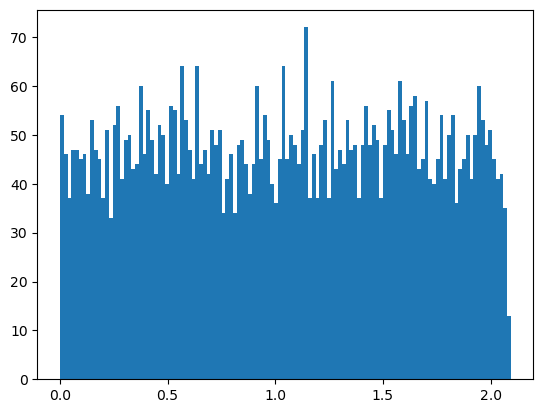

0.6295555555555555


0.6366197723675814

In [302]:
num_test=9000
dv_per = 6
accept_threshold=0.05
test_unwrapped = np.random.random((num_test,dv_per))*(2*np.pi)
#test_unwrapped = np.hstack((test_unwrapped))
test_unwrapped =  np.stack((np.ones_like(test_unwrapped), test_unwrapped), axis=-1)
angles = [get_three_angles(test_unwrapped[i],accept_threshold=accept_threshold, multi=False)[:,1] for i in range(num_test)]

plt.hist([a for ang in angles for a in ang], range=(0, 2*np.pi/3), bins=120)
plt.show()

print(len([a for ang in angles for a in ang])/num_test)
k = np.round(((accept_threshold*2)/np.pi)**-1)
n = dv_per


combinations(dv_per,3) * (accept_threshold*2/np.pi)

24

In [267]:
np.math.factorial(4)

24

## Generating the Data on Recall for Symmetry Filtered Data

In [ ]:
import hyperspy.api as hs
hs.set_log_level("ERROR")
hs.preferences.General.show_progress_bar=False
for i in range(6):
    num_crystals = [500, 1000,1500, 2000, 3000]
    simulations = [CrystalSTEMSimulation(Al_Structure, real_space_pixels=256, num_crystals=i) for i in num_crystals]
    with open("recall_sym_crystals"+str(i)+".txt","w+") as f:
        f.write("num_crystals, recall, false positives \n")

        for s, num_crystal in zip(simulations, num_crystals):
            import hyperspy.api as hs
            from scipy.spatial import KDTree
            arr = s.make_4d_nano(num_electrons=10)
            ground_truth_vectors = s.vectors
            signal = hs.signals.Signal2D(arr)
            signal.set_signal_type("electron_diffraction")
            signal = signal.as_lazy()
            signal.rechunk((32,32))

            filtered = signal.filter("gaussian_filter",
                                     sigma=(1,1,0,0))
            template = filtered.template_match_disk(disk_r=5,
                                                    subtract_min=False,
                                                        show_progressbar=False)
            template.data[:,:,:, 0:5]=0
            template.data[:,:,:,-5:]=0
            template.data[:,:, 0:5, :]=0
            template.data[:,:,-5:, :]=0

            signal.axes_manager.signal_axes[0].offset=-1
            signal.axes_manager.signal_axes[1].offset=-1
            signal.axes_manager.signal_axes[1].scale=1/32
            signal.axes_manager.signal_axes[0].scale=1/32

            pks = template.find_peaks(threshold_abs=0.5,
                                      interactive=False,
                                      show_progressbar=False,
                                      get_intensity=True)
            from pyxem.signals.diffraction_vectors import DiffractionVectors
            vect = DiffractionVectors.from_peaks(pks,
                                                 center= (32, 32, 0),
                                                 calibration=(1/32,1/32, 1))

            filt = vect.map(filter_mag,
                            min_mag= .05,
                            max_mag = .85,
                            show_progressbar=False, inplace=False)

            vectunwrapped = filt.map(unwrap, inplace=False, ragged=True, output_dtype=object, output_signal_size=())
            angles = vectunwrapped.map(get_three_angles,
                                         inplace=False,
                                         ragged=True,
                                         output_dtype=object,
                                         output_signal_size=(),
                                         accept_threshold=.075,
                                        k_threshold=.1)

            angles.compute()
            flat_angles = angles.flatten_diffraction_vectors()
            clusterd_angles = flat_angles.cluster_vectors(real_space_distance_threshold=1.5,
                                                          recip_space_distance_threshold=.1,
                                                          reciporical_space_columns=(2,3),
                                                          min_samples=5,
                                                          min_vectors=90)

            means = clusterd_angles.map_vectors(column_mean, columns=[0,1,2,3,4,5], dtype=float, shape=(6,))

            filtered_coords = s.get_coords(.1,0.85)
            filtered_centers = [cen for cen, c in zip(s.centers, filtered_coords) if len(c)>1]
            filtered_coords = [c for c in filtered_coords if len(c)>1]

            ground_truth_angles = []
            for c in filtered_coords:
                unwrapped = unwrap(c)
                ground_truth_angles.append(get_three_angles(unwrapped,accept_threshold=0.1,  k_threshold=.1))
            # Get the center for only those vectors with some high degree of symmetry
            filtered_centers = np.array([c for c, gt in zip(filtered_centers, ground_truth_angles) if len(gt)>0])
            min_angle = np.array([np.min(a[:,1]) for a in ground_truth_angles if len(a)>0])

            symmetries = np.hstack([filtered_centers, min_angle[:,np.newaxis]]) # x, y, phi
            filtered_mean = means[:, (0,1,3)][np.logical_not(np.any(np.isnan(means[:, (0,1,3)]), axis=1))]
            recall = test_recall(symmetries,
                                 filtered_mean,
                                 indexes2=np.array((2,)), 
                                 r1=10, 
                                 r2=.05,)

            false_positives = test_false_positives(symmetries,
                                                   filtered_mean,
                                                   indexes2=np.array((2,)), 
                                                   r1=10, 
                                                   r2=.05,)
            print("Recall", recall)
            print("False Positives", false_positives)
            f.write(str(num_crystal)+", " + str(recall)+", "+ str(false_positives)+"\n")
        
        

## Plotting Symmetry Filtered Data

In [36]:
num_crystals = [500, 1000,1500, 2000, 3000 ]
simulations = [CrystalSTEMSimulation(Al_Structure, real_space_pixels=256, num_crystals=i) for i in num_crystals]

In [37]:
sym_recall = [np.loadtxt("recall_sym_crystals"+str(i)+".txt", delimiter=",", skiprows=1) for i in range(6)]
mean_sym_recall = np.mean(sym_recall, axis=0)
std_sym_recall = np.std(sym_recall, axis=0)

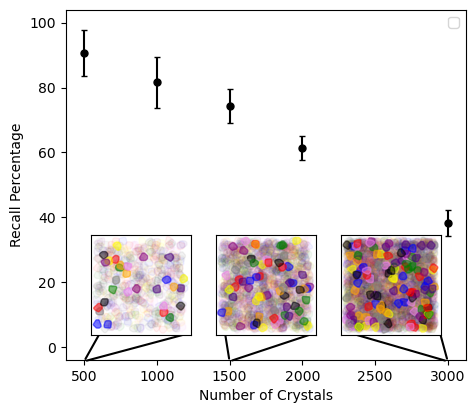

In [38]:
fig = plt.figure(figsize=(5,5))

axs = fig.add_axes((.15,.15, 0.8,0.7))
axs.errorbar(mean_sym_recall[:,0],
             mean_sym_recall[:,1]*100,
             std_sym_recall[:,1]*100,
             capsize=2, color="black",ls="none",
             marker="o", markersize=5,)


axs.set_xlabel("Number of Crystals")
axs.set_ylabel("Recall Percentage")
axs.set_ylim(-4,104)

axs2 = fig.add_axes((.2,.2, 0.2,0.2))

axs3 = fig.add_axes((.45,.2, 0.2,0.2))

axs4 = fig.add_axes((.7,.2, 0.2,0.2))

for ax in [axs2,axs3,axs4]:
    ax.set_xticks([])
    ax.set_yticks([])

simulations[0].plot_real_space(ax=axs2, alpha=0.05)
simulations[0].plot_real_space(ax=axs2, remove_non_symmetric=True, alpha=0.5)
simulations[2].plot_real_space(ax=axs3, alpha=0.05)
simulations[2].plot_real_space(ax=axs3, remove_non_symmetric=True, alpha=0.5)
simulations[-1].plot_real_space(ax=axs4, alpha=0.05)
simulations[-1].plot_real_space(ax=axs4, remove_non_symmetric=True, alpha=0.5)

for a, i,c in zip([axs2, axs3, axs4], [0,2,-1], corners):
    axs.annotate("", xy=(num_crystals[i],-4.5), xytext=(c, .16), xycoords="data",
                 textcoords="figure fraction",
                 arrowprops=dict(facecolor='black',arrowstyle="-", lw=1.5),annotation_clip=False)
    axs.annotate("", xy=(num_crystals[i],-4.5), xytext=(c+0.18, .16), xycoords="data",
                 textcoords="figure fraction",
                 arrowprops=dict(facecolor='black',arrowstyle="-", lw=1.5),annotation_clip=False)
    
fig.savefig("Figures/Figure7-RecallOfSymmetricCrystals.png",bbox_inches="tight" )
plt.show()

In [39]:
s = CrystalSTEMSimulation(Al_Structure, real_space_pixels=256, num_crystals=3000)

In [213]:
arr = s.make_4d_nano(num_electrons=10)
ground_truth_vectors = s.vectors
signal = hs.signals.Signal2D(arr)
signal.set_signal_type("electron_diffraction")
signal = signal.as_lazy()
signal.rechunk((32,32))

filtered = signal.filter("gaussian_filter",
                         sigma=(1,1,0,0))
template = filtered.template_match_disk(disk_r=5,
                                        subtract_min=False,
                                            show_progressbar=False)
template.data[:,:,:, 0:5]=0
template.data[:,:,:,-5:]=0
template.data[:,:, 0:5, :]=0
template.data[:,:,-5:, :]=0

signal.axes_manager.signal_axes[0].offset=-1
signal.axes_manager.signal_axes[1].offset=-1
signal.axes_manager.signal_axes[1].scale=1/32
signal.axes_manager.signal_axes[0].scale=1/32

pks = template.find_peaks(threshold_abs=0.5,
                          interactive=False,
                          show_progressbar=False,
                          get_intensity=True)
from pyxem.signals.diffraction_vectors import DiffractionVectors
vect = DiffractionVectors.from_peaks(pks,
                                     center= (32, 32, 0),
                                     calibration=(1/32,1/32, 1))

filt = vect.map(filter_mag,
                min_mag=.05,
                max_mag = .85,
                show_progressbar=False, inplace=False)

vectunwrapped = filt.map(unwrap, inplace=False, ragged=True, output_dtype=object, output_signal_size=())


In [214]:
angles = vectunwrapped.map(get_three_angles,
                             inplace=False,
                             ragged=True,
                             output_dtype=object,
                             output_signal_size=(),
                             accept_threshold=.1,
                             k_threshold=.1)

angles.compute()
flat_angles = angles.flatten_diffraction_vectors()

[##############################          ] | 77% Completed | 573.64 ss


KeyboardInterrupt



In [ ]:
clusterd_angles = flat_angles.cluster_vectors(real_space_distance_threshold=1.5,
                                              recip_space_distance_threshold=.1,
                                              reciporical_space_columns=(2,3),
                                              min_samples=5,
                                              min_vectors=50,
                                             )

means = clusterd_angles.map_vectors(column_mean, columns=[0,1,2,3,4,5], dtype=float, shape=(6,))

filtered_coords = s.get_coords(.1,0.85)
filtered_centers = [cen for cen, c in zip(s.centers, filtered_coords) if len(c)>1]
filtered_coords = [c for c in filtered_coords if len(c)>1]

ground_truth_angles = []
for c in filtered_coords:
    unwrapped = unwrap(c)
    ground_truth_angles.append(get_three_angles(unwrapped,accept_threshold=0.1,  k_threshold=.1))
# Get the center for only those vectors with some high degree of symmetry
filtered_centers = np.array([c for c, gt in zip(filtered_centers, ground_truth_angles) if len(gt)>0])
min_angle = np.array([np.min(a[:,1]) for a in ground_truth_angles if len(a)>0])


symmetries = np.hstack([filtered_centers, min_angle[:,np.newaxis]]) # x, y, phi
filtered_mean = means[:, (0,1,3)][np.logical_not(np.any(np.isnan(means[:, (0,1,3)]), axis=1))]

recall = test_recall(symmetries,
                     filtered_mean,
                     indexes2=np.array((2,)), 
                     r1=10, 
                     r2=.05,)

false_positives = test_false_positives(symmetries,
                                       filtered_mean,
                                       indexes2=np.array((2,)), 
                                       r1=10, 
                                       r2=.05,)
print("Recall", recall)
print("False Positives", false_positives)



In [ ]:
from scipy.spatial import distance_matrix
def test_recall(ground_truth,
                test,
                r1=10, 
                r2=1,
                indexes1=[0,1],
                indexes2=[2,3],
                get_true_positives=False,
               ):
    """Testing to see if every single ground truth point has a test point equivilent"""
    test_tree = KDTree(test[:, indexes1])
    test_indexes = test_tree.query_ball_point(ground_truth[:,indexes1],
                                                    r=r1)
    all_recall = []
    for ind, t in zip(test_indexes, ground_truth):        
        if (len(ind)>0):
            gt_near_test_point = t[indexes2]
            test_points = test[ind, indexes2]            
            if len(indexes2)==1:
                test_points = np.array([[t,0] for t in test_points])
                gt_near_test_point = np.array([[t,0] for t in gt_near_test_point])
            test_subtree = KDTree(test_points)
            test_subindexes = test_subtree.query_ball_point(gt_near_test_point,
                                                                  r=r2)
            all_recall.append(np.any([len(t)>0 for t in test_subindexes]))
        else:
            all_recall.append(False)
    return np.sum(all_recall)/ len(all_recall)


def test_false_positives(ground_truth,
                         test,
                         r1=10, 
                r2=1,
                indexes1=[0,1],
                indexes2=[2,3],
                get_true_positives=False,
               ):
    """Testing to see if every single test point has a ground truth point equivilent"""

    gt_tree = KDTree(ground_truth[:,indexes1])
    gt_indexes = gt_tree.query_ball_point(test[:, indexes1],
                                              r=r1)
    all_recall = []
    for ind, t in zip(gt_indexes, test):        
        if (len(ind)>0):
            gt_near_test_point = t[indexes2]
            test_points = ground_truth[ind, indexes2]            
            if len(indexes2)==1:
                test_points = np.array([[t,0] for t in test_points])
                gt_near_test_point = np.array([[t,0] for t in gt_near_test_point])
            gt_subtree = KDTree(gt_near_test_point)
            gt_subindexes = gt_subtree.query_ball_point(test_points,
                                                                  r=r2)
            all_recall.append(np.any([len(t)>0 for t in gt_subindexes]))
        else:
            all_recall.append(False)
    return (np.sum(all_recall)/ len(all_recall))
        

        
    

In [ ]:
flat_angles = angles.flatten_diffraction_vectors()
clusterd_angles = flat_angles.cluster_vectors(real_space_distance_threshold=1.5,
                                              recip_space_distance_threshold=.2,
                                              reciporical_space_columns=(2,3),
                                              min_samples=5,
                                              min_vectors=50)

means = clusterd_angles.map_vectors(column_mean, columns=[0,1,2,3,4,5], dtype=float, shape=(6,))

In [ ]:
angles.inav[169, 15].data

In [ ]:
signal.axes_manager.signal_axes[0].offset=-1
signal.axes_manager.signal_axes[1].offset=-1
signal.axes_manager.signal_axes[1].scale=1/32
signal.axes_manager.signal_axes[0].scale=1/32

In [ ]:
un, counts = np.unique(clusterd_angles.data[:,-1], return_counts=True)

In [ ]:
filtered_coords = s.get_coords(.1,0.85)
filtered_centers = [cen for cen, c in zip(s.centers, filtered_coords) if len(c)>1]
filtered_coords = [c for c in filtered_coords if len(c)>1]

ground_truth_angles = []
for c in filtered_coords:
    unwrapped = unwrap(c)
    ground_truth_angles.append(get_three_angles(unwrapped,accept_threshold=0.1,  k_threshold=.1))
# Get the center for only those vectors with some high degree of symmetry
filtered_centers = np.array([c for c, gt in zip(filtered_centers, ground_truth_angles) if len(gt)>0])
min_angle = np.array([np.min(a[:,1]) for a in ground_truth_angles if len(a)>0])

In [ ]:
offsets, colors, colors_by_index = angles_to_markers(clusterd_angles, signal)

In [ ]:
vert = clusterd_angles.map_vectors(points_to_poly_collection,
                                 dtype=object)
vert = [v for v in vert]

In [ ]:
centers = hs.plot.markers.Circles(offsets=filtered_centers[:,::-1], sizes=3,)

In [ ]:
%matplotlib ipympl
facecolors = np.empty(signal.axes_manager.navigation_shape, dtype=object)
for i in np.ndindex(signal.axes_manager.navigation_shape):
    facecolors[i]=("none",)
    
c = hs.plot.markers.Circles(offsets=offsets, sizes=.05,
                            facecolor=facecolors,
                            color=colors, alpha=0.5)
p = hs.plot.markers.Polygons(verts=vert, 
                             color=colors_by_index,
                             alpha=0.5)

signal.plot(vmax="95th")
signal.add_marker(c)
signal.add_marker(p,plot_on_signal=False)
signal.add_marker(centers,plot_on_signal=False)

## Plotting Recall For Symmetry Filtered Data

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from mpl_toolkits.axes_grid1.anchored_artists import AnchoredSizeBar
import matplotlib.font_manager as fm
fig, ax = plt.subplots(2,1, figsize=(4,4), sharex=True)
ax[0].hist(means[:,3], 
        bins=30,
        range=(0,2*np.pi/3))

ax[1].hist([a[1] for angle in ground_truth_angles for a in angle],
        bins=30,
        range=(0,2*np.pi/3))

#ax.hist(np.concatenate([angles.data[j][:,1]
#                            for j in np.ndindex(angles.data.shape) if np.shape(angles.data[j])[0]>0] ),
#            bins=60,
#            range=(0,2*np.pi/3))

ax[1].set_xticks([0, np.pi/6,
                   np.pi/5,  np.pi/4,
                   np.pi/3, 2*np.pi/5,
                   np.pi/2, 3*np.pi/5])
ax[1].set_xticklabels([r"$0$", r"$\frac{\pi}{6}$",
                        r"$\frac{\pi}{5}$",  r"$\frac{\pi}{4}$",
                        r"$\frac{\pi}{3}$", r"$\frac{2\pi}{5}$",
                        r"$\frac{\pi}{2}$",r"$\frac{3\pi}{5}$"], size=16)